# Sentiment Analysis - PyTorch

# 1 - Data Preprocessing

## 1.1. Download Dataset

We Will be downloading the dataset from google drive. This dataset is similar to "imdb-dataset-of-50k-movie-reviews" but is split into 2 with 25K in each.

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

## 1.2. Preprocess data

*  As the sentences have **&lt;br /&gt;&lt;br /&gt;** and **&lt;br /&gt;_________&lt;br /&gt;** i.e. html line breaks in them, they would be replaced with " ." prior to next steps of preprocessing, else the tags would lose meaning and dilute the sentences.
*  Inspecting the dataset reveled that there are **( ½, ¾, ,ª,³,º)** characters which are not numbers and hence have been cleaned explictly.
*  **TweetTokenizer** - seems to be smartly seperating numbers into different token i.e. "entries.3/10" is sepeared into two tokens "entries" and "310" so that we can remove 310 in next iterations, also  TweetTokenizer is idenityfing words like "cannot" and "gonna" as one token. TreebankWordTokenizer and word tokenizer are identifying "entries310" as one token and "cannot" as two tokens i.e. "can" and "not"  and hence TweetTokenizer is chosen.
*  As the corupus mostly contain english words, I have chosen to **remove english stop words exlcuding "n't","nt", "not", "no"** as they might contribute to sentiment.
*  **numbers** have also been removed
*  There are a lot of words which are **seperated by punctuation marks and not by space** for example - crazy-Chinese-musical-in-Paris-with-Barbet-Schroeder but.oh.dear.god.it.sounds.like.they're.all.reading.from.scripts. Hence for words with size greater than 20 punctuation marks and underscore have been replaced by space and for the rest punctuation marks have been removed.
*  **Hyperlinks** have also been removed using regex patterns
*  Using **Lemmatisation** over stemming as words like "flies" will be handled better using Lemmatisation
*  Underscores are handled differently than punctuation marks as there are some curse words censored by underscre example - f___ed, if we remove underscore completely then the meaning of the word changes entirely, hence tokens that **have _ at the beginning / end** have been handled using st.stip("_") and underscore in between tokens with size less than 20 have been left at they are.
*  A lot of **user exclaimed words** were also found in different forms (example - yeeshhhhhhhhhhhhhhhhh) and hence the most frequent ones have been identified and replaced by the respective words using regex patterns.
*  There are also multiple words which are **not seperated by space or punctuation mark**,(Example - heyijustleftmycoatbehind) these are hardcoded into a dict and then replaced

### 1.2.1. Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

labels = np.unique(sentiments_train)


lEnc = LabelEncoder()
lEnc.fit(labels)
label_train_n = lEnc.transform(sentiments_train)
label_test_n = lEnc.transform(sentiments_test)
numClass = len(labels)

print(labels)
print(lEnc.transform(labels))

### 1.2.2. Case Folding

In [ ]:
reviews_train = [s.lower() for s in reviews_train]
reviews_test = [s.lower() for s in reviews_test]

### 1.2.3. Remove HTML line breaks

As the content seems to be fetched from webpages and hence have a lot of line breaks, which needs to be dealt with prior ro removing punctuations, else the tags would lose meaning and dilute the sentences.

In [ ]:

import re
#There are some sentences like "<br /><br />_____________________________________<br /><br />" which will be replaced by .
reviews_train = [re.sub('<br /><br />_+<br /><br />','. ', s) for s in reviews_train]
reviews_test = [re.sub('<br /><br />_+<br /><br />','. ', s)  for s in reviews_test]

#There are a lot of <br /><br /> which indicate end of line
reviews_train = [s.replace("<br /><br />",". ") for s in reviews_train]
reviews_test = [s.replace("<br /><br />",". ") for s in reviews_test]



### 1.2.4. Removing Hyperlinks
Hyperlinks have been removed using regex patterns

Some examples:

http://en.wikipedia.org/wiki/Palisades_Nuclear_Generating_Station

http://en.wikipedia.org/wiki/Dispensationalism

http://www.dvdtalk.com/reviews/3199/thief-in-the-night-se-a/

www.geocities.com/paul_johnr

In [ ]:
import re

#Removing Hyperlinks starting with http, https and satisfying other requirements
reviews_train = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', s) for s in reviews_train]
reviews_test = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', s) for s in reviews_test]

#Removing Hyperlinks starting with www and satisfying other requirements
reviews_train = [re.sub('www.(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', s) for s in reviews_train]
reviews_test = [re.sub('www.(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', s) for s in reviews_test]


#Removing one specific url - ScheduleServlet?ACTION_DETAIL=DETAIL&FOCUS_ID=598947
reviews_train = [s.replace("scheduleservlet?action_detail=detail&focus_id=598947","") for s in reviews_train]
reviews_test = [s.replace("scheduleservlet?action_detail=detail&focus_id=598947","") for s in reviews_test]


### 1.2.5. Handle known long words
We have noticed some long words which are not seperated by space or punctuation marks and hence they have been added to a dictionary and replaced with respective multiple words with space

In [ ]:

longestwords_dict = {"It'saboutaguylookingforthewomanwhosavedhisgrandpafromtheNazis".lower(): "It's about a guy looking for the woman who saved his grandpa from the Nazis".lower(),
                     "LoveHateDreamsLifeWorkPlayFriends".lower():"Love Hate Dreams Life Work Play Friends".lower(),
                     "anothermaniacherewegoagain":"another maniac here we go again",
                     "heyijustleftmycoatbehind":"hey i just leftmy coat behind ",
                     "brianjonestownmassacre":"brian jonestown massacre",
                     "cough2Fast2Furiouscough".lower():"cough 2 Fast 2 Furious cough".lower(),
                     "realityshowfictionnal":"reality show fictional",
                     "hongkongmovieshootouts":"hongkong movie shootouts",
                     "worlddestructionthemes":"world destruction themes",
                     "redoredoredocopycopycopy":"redo redo redo copy copy copy",
                     "whateverherlastnameis":"what ever her last name is",
                     "specialagentfoxmulder":"special agent fox mulder",
                     "ammmmmbbbererrrrrrrrrgerrrrrrrssss":"amber gas"}
                     


for i, j in longestwords_dict.items():
  reviews_train = [s.replace(i, j) for s in reviews_train]
  reviews_test = [s.replace(i, j) for s in reviews_test]




### 1.2.6. Remove punctuations, ( ½, ¾) characters, other special symbols

In some cases multiple words are not seperated by space and hence for words with size more than 20 punctunation marks and underscore are replaced by space in other cases they have been removed.

In [ ]:
import re

def remove_punctuation_re(x):

    tempwords = x.split()
    bool_longword = False #flag to join the modified words
    #Checking to see if multiple words are seperated by symbols other than space and handling accordingly
    for i in range(len(tempwords)):
      if len(tempwords[i]) > 20:      
        tempwords[i] = re.sub(r'[^\w\s]',' ',tempwords[i])
        if tempwords[i].count("_") > 1:  #Identifying multiple words which are seperated by _ and not by space. Example: - elizabeth_perkins_in_miracle_on
          tempwords[i] = tempwords[i].replace("_"," ")  
        bool_longword = True # Updating flag to join the modified words 
    if bool_longword == True:
      x = " ".join(tempwords)


    x = re.sub(r'[^\w\s]','',x)
    #y = "".join(filter(lambda char: char in string.printable, x))
    x = x.replace("½","")
    x = x.replace("¾","")
    x = x.replace("º","") #appended to timeº
    x = x.replace("ª","")
    x = x.replace(""," ")
    x = x.replace("³"," 3") #2 instances of alien³
    x = x.replace("1ç","1") # one mention of "1ç is to expensive" and hence dealing with it so that it does not give a different intent for other words like nouns
    x=x.replace("יגאל","")   
    return x

reviews_train = [remove_punctuation_re(s) for s in reviews_train]
reviews_test = [remove_punctuation_re(s) for s in reviews_test]

### 1.2.7. Remove digits

In [ ]:
reviews_train = [re.sub('\d+','', s) for s in reviews_train]
reviews_test = [re.sub('\d+','', s) for s in reviews_test]

### 1.2.8. Tokenization

In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

reviews_train = [tknzr.tokenize(s) for s in reviews_train]
reviews_test  = [tknzr.tokenize(s) for s in reviews_test]

### 1.2.9. Handle tokens starting / ending with underscore

Some examples:
_told_
_bounce_
_penetrate_
_before_
_do_

In [ ]:
text_train_nsu=[]
for tokens in reviews_train:
  filtered_sentence = [w.strip("_") for w in tokens]
  text_train_nsu.append(filtered_sentence)



text_test_nsu=[]
for tokens in reviews_test:
    filtered_sentence =  [w.strip("_") for w in tokens] 
    text_test_nsu.append(filtered_sentence)


### 1.2.10. Stopwords removal
Removing english stop words except ["n't", "not", "no"] as they migth contribute to emotion.

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stop_words = sw.words('english')  #Only English Stopwords

# Some stop words might indicate a certain sentiment and hence whitelisting them
whitelist = ["n't", "not", "no","nt"]

text_train_ns=[]
for tokens in text_train_nsu:
  filtered_sentence = [w for w in tokens if (not w in stop_words) or (w in whitelist)]
  text_train_ns.append(filtered_sentence)
text_test_ns=[]
for tokens in text_test_nsu:
    filtered_sentence =  [w for w in tokens if (not w in stop_words) or (w in whitelist)] 
    text_test_ns.append(filtered_sentence)


### 1.2.11. Lemmatisation

In [ ]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

text_train_le1 = []
for tokens in text_train_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_train_le1.append(lemma_sentence)

text_test_le1 = []
for tokens in text_test_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_test_le1.append(lemma_sentence)



### 1.2.12. Number words, underscore tokens removal
One more parsing after tokenisation to remove the below tokens:
1. Empty
2. Only underscore in them
3. Only numbers and space in them

In [ ]:
text_train_le=[]
for tokens in text_train_le1:
  filtered_sentence = [w for w in tokens if (not w.replace(" ","").isdecimal()) and ( w.count("_") != len(w))]  #We are removing tokens with only numbers and _
  text_train_le.append(filtered_sentence)



text_test_le=[]
for tokens in text_test_le1:
    filtered_sentence = [w for w in tokens if (not w.replace(" ","").isdecimal()) and ( w.count("_") != len(w))]
    text_test_le.append(filtered_sentence)

### 1.2.13. Clean user exclaimed words

Below are most frequent user exclaimed words in the corpus. We have used regex patterns to replace them with correct form.

Please note that the below snippet takes around 6 mins for execution as it it looping over every token in training and test set. I have tried to place this prior to tokenization and loop over sentenes and found it be faster but returning more unique words at the end, probably tokenisation is helping in brining out these patterns. Hence I had to choose this trade off of 6 minutes for better preprocessing results.

In [ ]:
import re
import datetime

#print("Start Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))


for x in [text_train_le, text_test_le]:
  for sentence in x:
    #for word in sentence:
    for i in range(len(sentence)):
      sentence[i] = re.sub(r'^boo+$','boo',sentence[i]) #handle  booooooooooooooooooooooooooooooooooooooooooooooo
      sentence[i] = re.sub(r'^[a]h+a+(h+a+)+h*a*$','haha',sentence[i]) #handle  ahahahahahhahahahahahahahahahhahahahahahahah
      sentence[i] = re.sub(r'^zzz+$','zzz',sentence[i]) #handle  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
      sentence[i] = re.sub(r'^da+d+$','dad',sentence[i]) #handle  daaaaaaaaaaaaaaaaaddddddddd
      sentence[i] = re.sub(r'^s+o+$','so',sentence[i]) #handle  sssssssssssooooooooooooo
      sentence[i] = re.sub(r'^ca+ligula+$','caligula',sentence[i]) #handle  CAAAAAAAAAAAAAAAAAAAAAALIGULAAAAAAAAAAAAAAAAAAAAAAA, caligulaaaaaaaaaaaaaaaaa
      sentence[i] = re.sub(r'^no+[so]o*$','no',sentence[i]) #handle nooooooooooooooooooooo, nooooooooooooooooooooso
      sentence[i] = re.sub(r'^co+ff+i+n+$','coffin',sentence[i]) #handle coooofffffffiiiiinnnnn
      sentence[i] = re.sub(r'^ye+s+h*$','yes',sentence[i]) #handle yeeshhhhhhhhhhhhhhhhh
      sentence[i] = re.sub(r'^(blah)+$','blah',sentence[i]) #handle blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah
      sentence[i] = re.sub(r'^s+t+u+p+i+d+$','stupid',sentence[i]) #handle sssssssttttttttttuuuuuuuuuuuuuuuuuupppppiiiddd
      sentence[i] = re.sub(r'^ter+i+ble$','terrible',sentence[i]) #handle terrrrrrrrrrrrrrrriiiiiiiiiiiible
      sentence[i] = re.sub(r'^all+$','all',sentence[i]) #handle       allllllllllllllllllllllllllllll 
      sentence[i] = re.sub(r'^a+hh+$','ahh',sentence[i]) #handle       ahhhhhhhhhhhhhhhhhhhhhhhhhhh, aaaaaaaaaaaahhhhhhhhhhhhhh 
      sentence[i] = re.sub(r'^i+v+y+$','ivy',sentence[i]) #handle       iiiiiiiivvvvyyyyyyyyyyyyyyyy
      sentence[i] = re.sub(r'^uh+k+u+h+k+$','uhkuhk',sentence[i]) #handle       Uhhhhkkkkkkuuuuuhhhhhkkkkkk 
      sentence[i] = re.sub(r'^bo+r+in+g+$','boring',sentence[i]) #handle       boooooooorrrrrinngggggggg
      sentence[i] = re.sub(r'^goo+d$','good',sentence[i]) #handle       goooooooooooooooooooood
      sentence[i] = re.sub(r'^ho+t+$','hot',sentence[i]) #handle       hottttttttttttttttttttt
      sentence[i] = re.sub(r'^wo+nderful$','wonderful',sentence[i]) #handle       wooooooooooooooonderful
      sentence[i] = re.sub(r'^a+r+g+h+$','argh',sentence[i]) #handle       aaaaarrrrrrgggggghhhhhh   
      sentence[i] = re.sub(r'^je+sus+$','jesus',sentence[i]) #handle       jeeeeeeeesussssssssss
      sentence[i] = re.sub(r'^(spoilers)+$','spoliers',sentence[i]) #handle       spoilersspoilersspoilersspoilers 
      sentence[i] = re.sub(r'^(fantastic)+$','fantastic',sentence[i]) #handle       FANTASTICFANTASTICFANTASTIC 
      sentence[i] = re.sub(r'^sup[eu]+r+b+$','superb',sentence[i]) #handle       supurrrrb
      sentence[i] = re.sub(r'^aa+[hg]+$','aah',sentence[i]) #handle       aaaaah 
      sentence[i] = re.sub(r'^a+nd$','and',sentence[i]) #handle       aaaand 
      sentence[i] = re.sub(r'^all+r+i+ght$','alright',sentence[i]) #handle       alllriiiiight 
      sentence[i] = re.sub(r'^bh*a+d+$','bad',sentence[i]) #handle       baaaaaad 
      sentence[i] = re.sub(r'^coo+l$','cool',sentence[i]) #handle       coool
      sentence[i] = re.sub(r'^doo+m$','doom',sentence[i]) #handle       dooooom  
      sentence[i] = re.sub(r'^du+h+$','duh',sentence[i]) #handle       duhhh  
      sentence[i] = re.sub(r'^e+vil$','evil',sentence[i]) #handle       eeeevil 
      sentence[i] = re.sub(r'^funn+y+$','funny',sentence[i]) #handle       funnny
      sentence[i] = re.sub(r'^grrr+l*$','grr',sentence[i]) #handle       grrrrrr
      sentence[i] = re.sub(r'^he+a+r+t$','heart',sentence[i]) #handle       heeaaaaaaaaaart 
      sentence[i] = re.sub(r'^he+re$','here',sentence[i]) #handle       heeeeeere 
      sentence[i] = re.sub(r'^hell+o+$','hello',sentence[i]) #handle       helloooo          
      sentence[i] = re.sub(r'^[hu]mm+$','hmm',sentence[i]) #handle       hmmmmm          
      sentence[i] = re.sub(r'^hu+ge$','huge',sentence[i]) #handle       huuuuuge        
      sentence[i] = re.sub(r'^jee+z$','jeez',sentence[i]) #handle       jeeez     
      sentence[i] = re.sub(r'^li+fe$','life',sentence[i]) #handle       liiiiiiiiife  
      sentence[i] = re.sub(r'^lo+n+g+$','long',sentence[i]) #handle       looong  
      sentence[i] = re.sub(r'^lo+v+e+$','love',sentence[i]) #handle       loooooove  
      sentence[i] = re.sub(r'^mm+$','mm',sentence[i]) #handle       mmmmm  
      sentence[i] = re.sub(r'^mo+re$','more',sentence[i]) #handle       mooooooooooooore     
      sentence[i] = re.sub(r'^na+h*$','no',sentence[i]) #handle       naaaa  
      sentence[i] = re.sub(r'^o[oh]+h+$','ohh',sentence[i]) #handle       ohhhh  
      sentence[i] = re.sub(r'^oo+p+s$','oops',sentence[i]) #handle       oooops  
      sentence[i] = re.sub(r'^pla+in$','plain',sentence[i]) #handle       plaaaain  
      sentence[i] = re.sub(r'^ple+a[sz]e+$','please',sentence[i]) #handle       pleaseee  
      sentence[i] = re.sub(r'^re+a+ll+y+$','really',sentence[i]) #handle       reaaaaallly             
      sentence[i] = re.sub(r'^ri+ght$','right',sentence[i]) #handle       right  
      sentence[i] = re.sub(r'^slo+w$','slow',sentence[i]) #handle       sloooow    
      sentence[i] = re.sub(r'^shh+$','shh',sentence[i]) #handle       shhhhh        
      sentence[i] = re.sub(r'^shi+t+y*$','shit',sentence[i]) #handle       shittttttttttttttty 
      sentence[i] = re.sub(r'^st[uo]+pid+$','stupid',sentence[i]) #handle       stooooopid  
      sentence[i] = re.sub(r'^thing+$','thing',sentence[i]) #handle       thinggg    
      sentence[i] = re.sub(r'^too+$','too',sentence[i]) #handle       toooo        
      sentence[i] = re.sub(r'^u[gh]+h+$','ugh',sentence[i]) #handle       uggghh                    
      sentence[i] = re.sub(r'^ve+r+y+$','very',sentence[i]) #handle       verrrrry       
      sentence[i] = re.sub(r'^wa+y+$','way',sentence[i]) #handle       waaaaaaaaay                    
      sentence[i] = re.sub(r'^we+ll+$','well',sentence[i]) #handle       welll    
      sentence[i] = re.sub(r'^wha+[at]+$','what',sentence[i]) #handle       whaaaaatttt                    
      sentence[i] = re.sub(r'^why+$','why',sentence[i]) #handle       whyyyyyyyyyyyyyyyy
      sentence[i] = re.sub(r'^wo+[ho]+$','woho',sentence[i]) #handle       wooohooo    
      sentence[i] = re.sub(r'^ye+a+h+$','yeah',sentence[i]) #handle       yeahhhh                    
      sentence[i] = re.sub(r'^ya+y+$','yay',sentence[i]) #handle       yaaayy    
      sentence[i] = re.sub(r'^yippee+$','yippee',sentence[i]) #handle       yippeee
      sentence[i] = re.sub(r'^yum+$','yum',sentence[i]) #handle       yummm
 

#print("End Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))


# 2 - Model Implementation

## 2.1. Word Embeddings

### 2.1.1. Data Preprocessing for Word Embeddings

**Words occuring less than 6 times have been ignored**

After preprocessing the data we have 148137 words, which meant there are 11879450 skipgrams (for a windows size - 1) and for the model to go through this entire dataset it might take more than a day even with best possible hyper parameters.

Hence I have also tried with words occuring more than 5 times in the enitre corpus and experimented and found the below:

*   Number of words have been reduced to 33812 and skipgrams to 10920154, i.e. **9% decrease in the number of skipgrams**.
*   F1-score on the entire test data set was same i.e. 0.37
*   Model with words occuring more than 5 times was learning faster (as indicated by the decrease in loss).

Hence I have concluded to only proceed with words occuring more than 5 times.


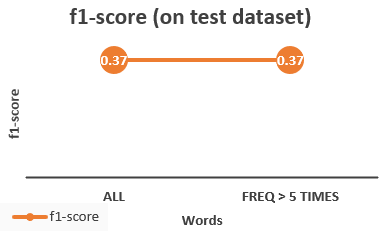


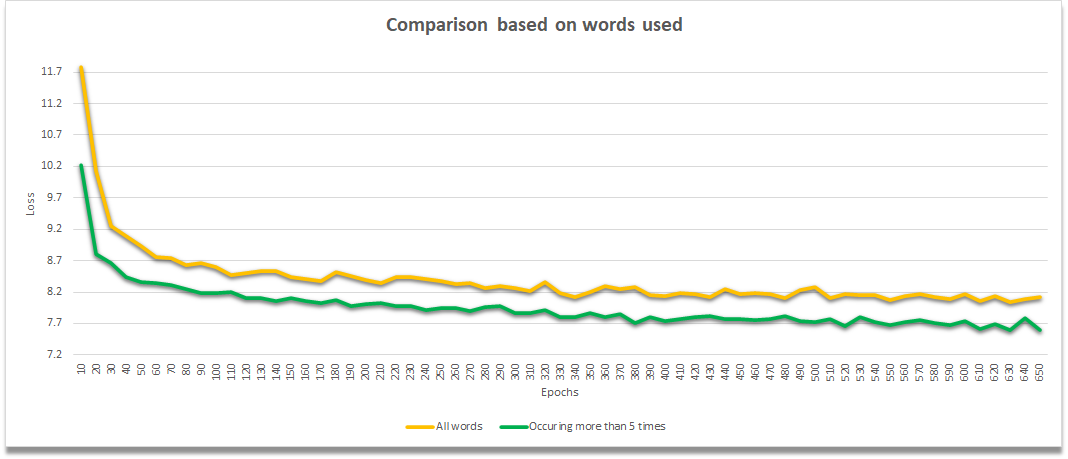

**Word2Vec with SkipGram model has been implemented**

I have tried Word2Vec with CBOW and Word2Vec with SkipGram models keeping other hyper parameters same and compared them loss and could not find one significantly better over other (as below). I have decided to go with SKipGram.

FastText was not considered as it is slower and computational time for word 2vec was already challenging.

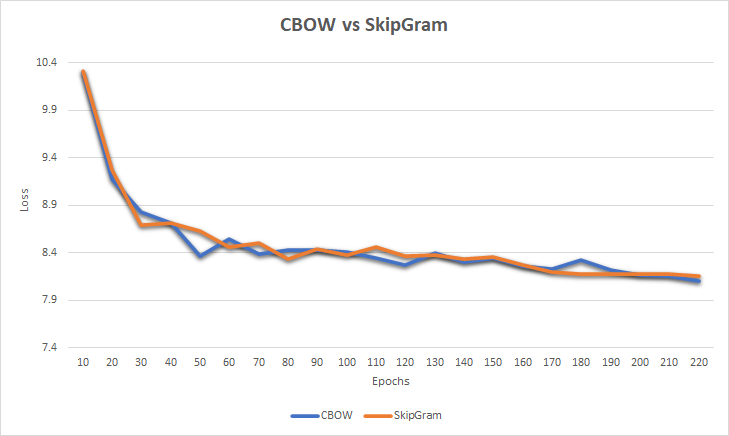

**Windows Size - 1 has been chosen**

*  After expermenting with windows size of 1,2 & 5 we have realised that with windows size 1 the loss is less and gradually decreasing (as in the below graph).
*  Most importantly with the increase in windows size the skipgrams (training data) multiplies and the model would need a lot of time (more days) to be trained on the entire data

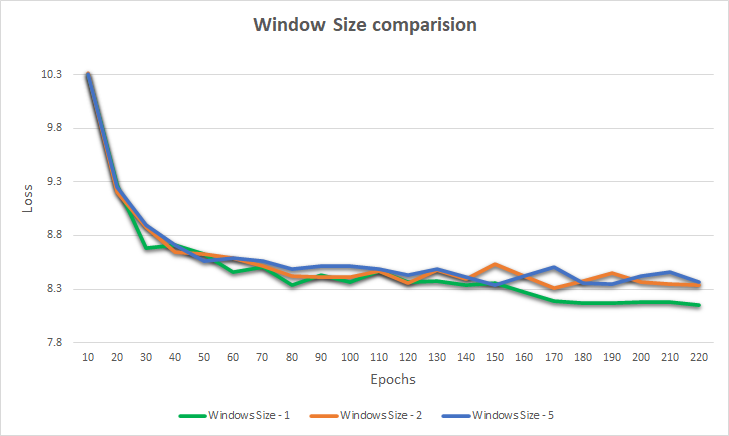

The below histogram displays the increase in skipgrams with the window size.

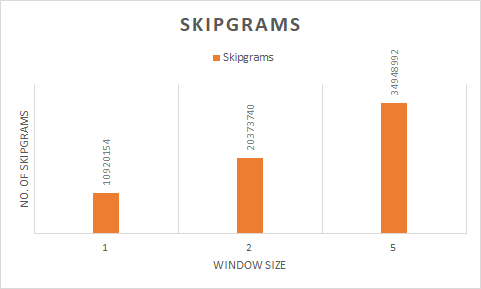

In [ ]:
import copy
import datetime

#Adding all words into a list called word_sequence
word_sequence = []
for corpus_temp in [text_train_le,text_test_le]:
  for sentence in corpus_temp:
    word_sequence.extend(sentence)


print("Total unique words:",len(set(word_sequence)))

#Using counter to count the number of occurences of each word
from collections import Counter
vocab_cnt = Counter()
vocab_cnt.update(word_sequence)
vocab_cnt = Counter({w:c for w,c in vocab_cnt.items() if c > 5})  #Ignoring words which have occured less than 6 times

print("Total unique words after ignoring words occuring less than 6 times:",len(vocab_cnt))

word_list = []  #List to store unique words which have occured more than 6 times


for k,v in vocab_cnt.items():
  word_list.append(k)


#print(len(word_list))
word_list = list(set(word_list))
#print(len(word_list))
word_list.sort()

# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

voc_size = len(word_list)

skip_grams = []

#Creating skipgrams
for corpus in [text_train_le,text_test_le]:
  for sentence in corpus:
    for i in range(1, len(sentence) - 1):
    #for i in range(2, len(sentence) - 2):  #Uncomment for window size - 2 
    #for i in range(5, len(sentence) - 5):   #Uncomment for window size - 5 
      try:
        target = word_dict[sentence[i]]
        #context = [word_dict[sentence[i - 5]],word_dict[sentence[i - 4]],word_dict[sentence[i - 3]],word_dict[sentence[i - 2]],word_dict[sentence[i - 1]], word_dict[sentence[i + 1]],word_dict[sentence[i + 2]],word_dict[sentence[i + 3]],word_dict[sentence[i + 4]],word_dict[sentence[i + 5]]] #Uncomment for window size - 5
        #context = [word_dict[sentence[i - 2]],word_dict[sentence[i - 1]], word_dict[sentence[i + 1]],word_dict[sentence[i + 2]]]  #Uncomment for window size - 2 
        context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        for w in context:
          #skip_grams.append([w,target])  #Uncomment for CBOW
          skip_grams.append([target, w])  #Skip Gram
      except:
        continue

print("Total number of skipgrams :",len(skip_grams))



   

#### 2.1.1.1. Input preparation for Word Embedding Model

The function prepare_batch will take skipgrams and size as input.

The function will randomly chosen the required number of skipgrams, from the entire skipgram set and create one hot encoded vectors required for the model.

In [ ]:
def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        input_temp = [0]*voc_size   #length of the one hot vector will be the total number of unique words.
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(data[i][1])  # context word
    return np.array(random_inputs), np.array(random_labels)

### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

**Learning Rate - 0.01 has been chosen**

After experimenting with different values for learning rate i.e. 0.01, 0.02, 0.05 it was observed that with 0.05 the model does not seem to be convering and 0.02 the converge is slow and hence 0.01 was chosen for training. Please refer to below visualization.

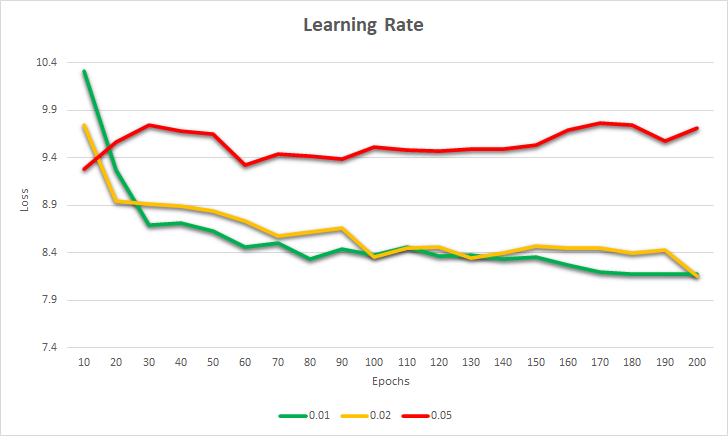

**Adam Optimizer has been implemented**

We have tried SGD and Adam optimizer on Word2Vec and noticed that the model is learning faster and the loss is reducing with Adam Optimizer.

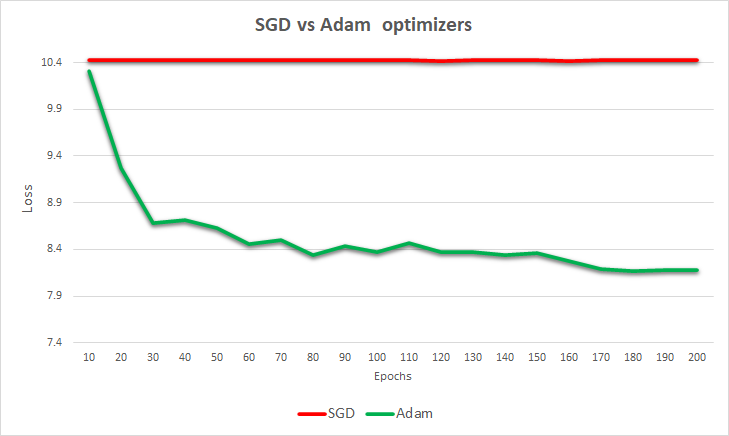

**Batch Size - 4000 seems to be better**

I have experimented with batch size 1000,2000, 4000 and it was observed that with more batch size the model seems to be learning better.

I could not increase more than 4000 as colab was crashing with message "Your session crashed after using all available RAM" and hence batch size was set to 4000.

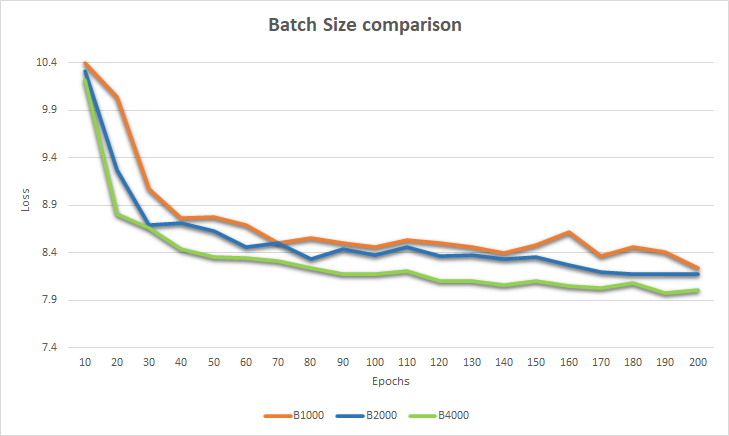

**Embedding Size - 200 has been chosen**

I have tried embedding size 100, 200 but did not notice any significant difference in loss. I have opted to go for 200 as I felt 100 might not be suitable to represent the lot of words we have in the corpus.

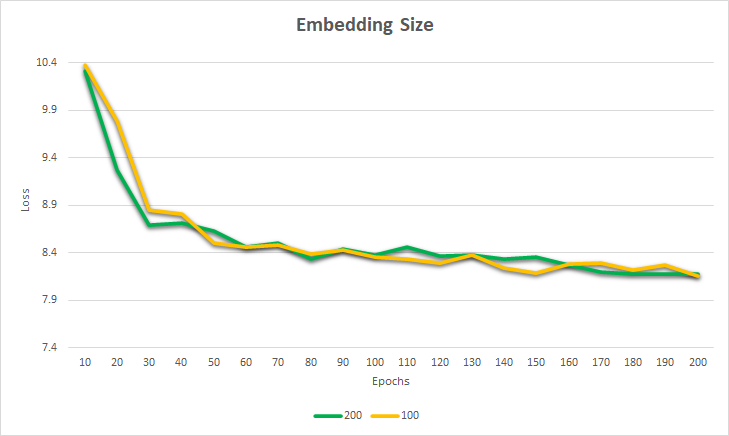

**Epochs - 750**

It seems that as the epochs increase the loss decrease and hence the model has been executed for as many epochs as possible i.e. 750.

This took more than 8 hours and beyond which colab would stop responding etc. We also see that the rate of decrease is less as the epochs progress. Considering both these points I set epochs to 750.

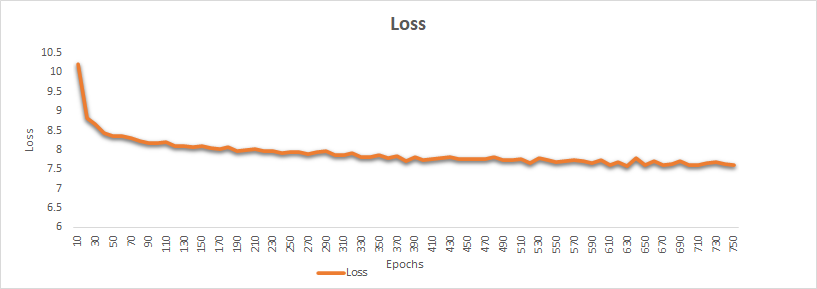

In [ ]:
#hyperparameter declaration

learning_rate = 0.01
batch_size = 4000 
embedding_size = 200
total_epoch = 750 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #Using GPU if available
class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size,bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size,bias=False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out   


### 2.1.3. Train Word Embeddings Model

*The original model was trained with the above set hyperparameters (batch size - 4000, epochs - 750).*

*The below output is only a reference one with 250 batch size, 250 epochs as executing it again with the original hyperparamters will take a lot of hours.*

In [ ]:
skip_gram_model = SkipGram().to(device)
criterion = nn.CrossEntropyLoss() #please note we are using "CrossEntropyLoss" here
optimizer = optim.Adam(skip_gram_model.parameters(), lr=learning_rate)

for epoch in range(total_epoch):
    #print("Epoch "+str(epoch)+" Start Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) #uncomment during debug
    inputs,labels = prepare_batch(skip_grams, batch_size)
    inputs_torch = torch.from_numpy(np.array(inputs)).float().to(device)
    outputs_torch = torch.from_numpy(np.array(labels)).to(device)
    skip_gram_model.train()
    # 1. zero grad
    optimizer.zero_grad()
    # 2. forword propagation
    predoutput_torch = skip_gram_model(inputs_torch)
    # 3. calculate loss
    loss = criterion(predoutput_torch, outputs_torch)
    # 4. back propagation
    loss.backward()
    optimizer.step()
    #print("Epoch "+str(epoch)+" End Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) #uncomment during debug
    if epoch % 10 == 9:
      print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))


#Extracting weights i.e. vectors for words
weight1 = skip_gram_model.linear1.weight
trainedword2vec_embeddings = weight1.detach().T.cpu().numpy()


### 2.1.4. Save Word Embeddings Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
Word2VecModelName = "wordEmbeddingAssignment1-"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")+".pt" #Adding current time to filename so that old models are not lost
path = F"/content/gdrive/My Drive/"+Word2VecModelName 
torch.save(skip_gram_model, path)
drive.flush_and_unmount()

### 2.1.5. Load Word Embeddings Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/"+Word2VecModelName   #Load above saved model
#path = F"/content/gdrive/My Drive/wordEmbeddingAssignment1-B4000_E750_LR0.01.pt" #Uncomment this for loading a different model then above saved one
try:
  modelword2vec = torch.load(path)
except:
  modelword2vec = torch.load(path, map_location=torch.device('cpu')) #Lod into CPU if GPU is not available

drive.flush_and_unmount()
modelword2vec.eval()
#Extract weights
weight1 = modelword2vec.linear1.weight
trainedword2vec_embeddings = weight1.detach().T.cpu().numpy()

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

In the very first runs we noticed the below:
*   Some rarely used symbols in char dictionary **(like  ½, ¾, ,ª,³,º)** and hence they have been dealt in section 1.2.6. We decided to remove as there were less than 2 occurences of each
*   The length of longest word was 72 and hence 72 one  hot vectors would be required for the neural network. On examination I realised there were words like words which are **seperated by punctuation marks and not by space** for example - crazy-Chinese-musical-in-Paris-with-Barbet-Schroeder and so we have replaced punctuation marks with space for words longer than 20 in section 1.2.6

These were done in the initials steps as they also helped in sanitised the word corpus. We have noticed that the max  word length was then recuded to 20 which meant the model execution time was drastically reduced. 

In [ ]:
chars = []
wordlen = []

for word in word_list:
  chars+=list(word)  #adding all characters to chars list for words used in word2vec embedding
  wordlen.append(len(word))  #adding the length of each word to wordlen list

char_arr = list(set(chars))  #adding unique characters in char_arr

char_dic = {n: i for i, n in enumerate(char_arr)}  #Creating a dictionary for indexing characters when required

char_dic_len = len(char_dic) #This will be the length of one hot vector for every character

maxword_len = max(wordlen)  
print("Maximum word length : ",maxword_len)

#### 2.2.1.1. Input preparation for Character Embedding Model

The function make_char_batch will take word_list (i.e. list of unique words) and batch size for character emebedding model as input.

The function will randomly chose the required number of word, from the entire word list set and create input as below:

* The number of input nodes to the model has to be fixed but different words may have different length and hence for words smaller than longest words, we will add 0 for the remaining spaces while creating one hot vectors
* The size of each one hot vector will be the length of charcter dictionary i.e. number of unique characters in the corpus
* Output for character embedding model will the be word2vec generated from word embedding model.


In [ ]:
def make_char_batch(wordlist,size):
    input_batch = []
    output_batch = []

    random_index = np.random.choice(range(len(wordlist)), size, replace=False)

    for i in random_index:
        input_data = [char_dic[n] for n in wordlist[i]] #Getting the index of every character from char dictionary for very letter in the word.

        #Adding 0 to the vector in case the word is smaller than the longest word
        diff = maxword_len - len(input_data)
        for x in range(diff):
          input_data.append(0)

        input_batch.append(np.eye(char_dic_len)[input_data])

        output_data  = trainedword2vec_embeddings[i]         # Output data - Vector of the word generated from word2vec model
        output_batch.append(output_data)
    return input_batch, output_batch

### 2.2.2. Build Character Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

**Learning Rate - 0.05**

I tried with 0.005, 0.01, 0.05 learning rates and found out there is no significant difference in the loss. I decided to set 0.05 so that the model can learn faster.

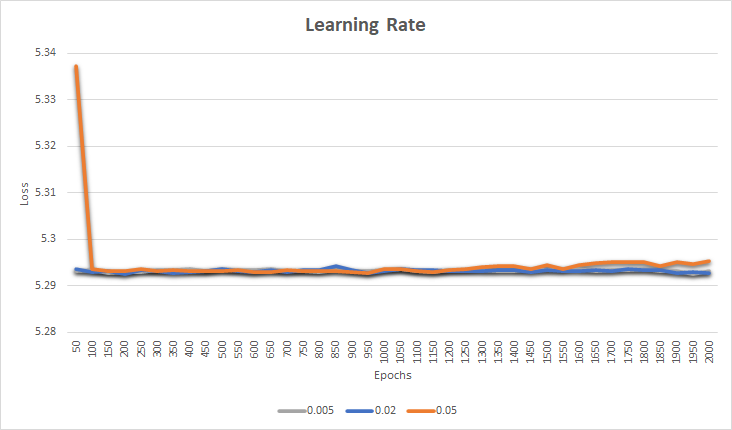

**Batch Size - 4000**

I have tried with batches of 2000 & 4000 and noticed no significant difference in the loss. I have decided to have 4000 per batch so that model can look at as much as train on as much as data possible.

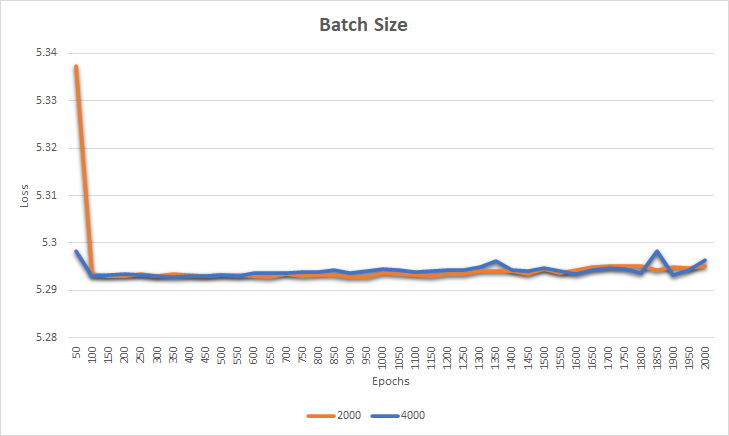

**Hidden Layer Size - 50**

I have tried with different hidden layers i.e. 50, 128, 200 while there was no siginificant change in the loss the time slightly increased as I increased number of hidden layers. Hence i have set hidden layer size to 50 so that the model can get trained faster.

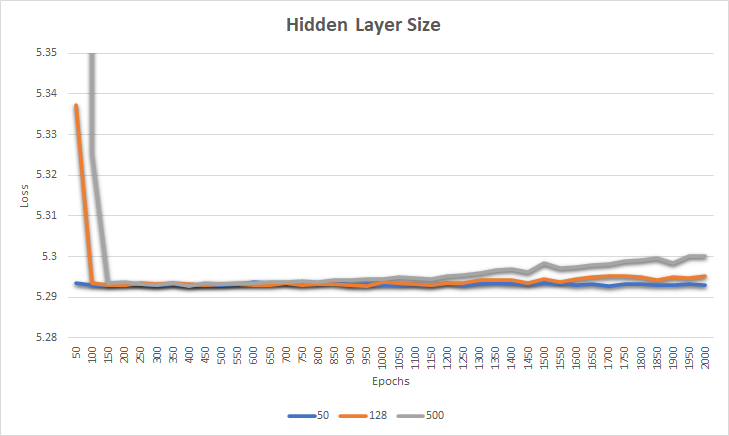


**Drop Out Rate - 0.2**

I have tried with different drop out rates i.e. 0.1, 0.2, 0.5 and noticed that there is no changes in the loss of the model and hence set drop out rate as 0.2 as random one of the 3 values. Please note in the below graph y-axis is magnified to 3 decimal places, else there was no difference visible :)

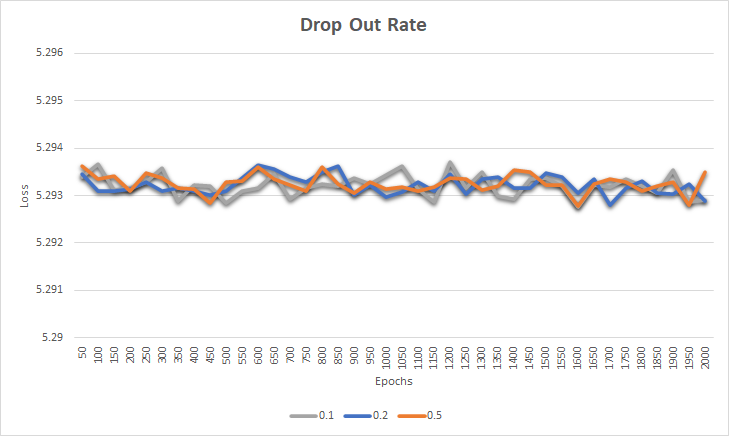

**Epochs - 2000**

After running the model for 8000 epochs, there was still no significant change in loss and hence set the epochs to 2000 with an intention not to overfit the model.

The visualization also contains aother run on 2000 epochs confirming that there is no significant change even with different weights initialized.


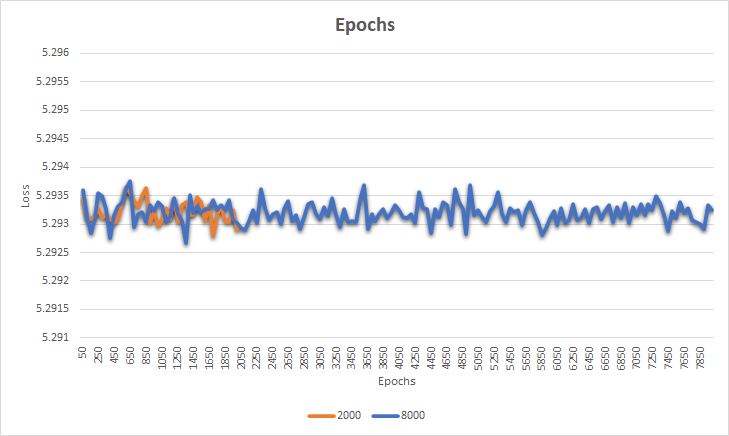

**input nodes of the NN** = number of unique characters, as we will have to pass the index of each character in the word. Hence it will be length of the character dictionary.

**outpur nodes of the NN** = embedding size of word2vec as we want to train our chracters based embedding to the word embedding generated from word embedding model. Hence it will be 200 (as set for word2vec).

**Loss Function** = I have used L1Loss function to calculate MSE of target and output while determining loss, as our output is a vector and not a scalr value I could not use NLLLoss function.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class CharNet(nn.Module):
    def __init__(self):
        super(CharNet, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, sentence):
        
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        log_output = F.log_softmax(z, dim=1)
        return log_output,hidden_out

### 2.2.4. Train Character Embeddings Model

In [ ]:
learning_rate = 0.05
n_hidden = 50
total_epoch = 2000
char_batch_size =4000

n_input = char_dic_len
n_class = embedding_size

In [ ]:

# Move the model to GPU
charnet = CharNet().to(device)
# Loss function and optimizer
#criterion = nn.NLLLoss()
criterion = nn.L1Loss() #Mean Absolute Error loss function
optimizer = optim.Adam(charnet.parameters(), lr=learning_rate)

#Uncomment while debugging
#print("learning_rate",learning_rate)
#print("n_hidden",n_hidden)
#print("total_epoch",total_epoch)
#print("char_batch_size",char_batch_size)


for epoch in range(total_epoch):
    #if epoch < 10: 
    #  print("Epoch "+str(epoch)+" Start Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))  #Uncomment while debugging
    # Preparing input
    input_batch, target_batch = make_char_batch(word_list,char_batch_size)
    # Convert input into tensors and move them to GPU by uting tensor.to(device)
    input_batch_torch = torch.from_numpy(np.array(input_batch)).float().to(device)
    target_batch_torch = torch.from_numpy(np.array(target_batch)).to(device)  
    
    # Set the flag to training
    charnet.train()
    
    # forward + backward + optimize
    outputs,_ = charnet(input_batch_torch)
    #print(outputs[0].size())
    #print(target_batch_torch[0].size()) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    charnet.eval()
    outputs,_ = charnet(input_batch_torch) 
    
    # Evaluation loss
    loss = criterion(outputs, target_batch_torch)
    #if epoch < 10:
    #  print("Epoch "+str(epoch)+" End Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))  #Uncomment while debugging
    if epoch % 50 == 49:
      print('Epoch: %d, loss: %.5f' %(epoch + 1, loss.item()))
print('Finished Training')



charnet.eval()
_,hidden_state = charnet(input_batch_torch)


### 2.2.5. Save Character Embeddings Model

In [ ]:
import datetime

from google.colab import drive
drive.mount('/content/gdrive')
CharModelName = "CharEmbeddingAssignment1-"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")+"_LearningRate"+str(learning_rate)+"_n_hidden"+str(n_hidden)+"_Epoch"+str(total_epoch)+"_batch_size"+str(char_batch_size)+".pt"

charpath = F"/content/gdrive/My Drive/"+CharModelName 
torch.save(charnet, charpath)
drive.flush_and_unmount()

### 2.2.6. Load Character Embeddings Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#CharModelName= "CharEmbeddingAssignment1-21-04-2020-08-30_LearningRate0.05_n_hidden50_Epoch2000_batch_size4000.pt"
charmodel_path = F"/content/gdrive/My Drive/"+CharModelName  #Load above saved model

CharEmbedModel= torch.load(charmodel_path)

drive.flush_and_unmount()
CharEmbedModel.eval()

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

#### 2.3.1.1 Estimate length of reviews (for analysis)

Performing some visualization analysis on the length of reviews to decide on preprocessing steps.

In [ ]:
import matplotlib.pyplot as plt
len_list = [len(s) for s in text_train_le]  #Storing length of reviews in training set.

#Creating a box plot for length of reviews
fig = plt.figure(1)
fig.suptitle('Box Plot for length of reviews', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.boxplot(len_list,vert=False,meanline=True,showmeans=True)
ax.set_xlabel('Number of words')

#Creating a histogram for length of reviews
fig = plt.figure(2)
fig.suptitle('Histogram for length of reviews', fontsize=14, fontweight='bold')
bx = fig.add_subplot(111)
bx.hist(len_list)
bx.set_xlabel('Number of words')
bx.set_ylabel('Number of reviews')


plt.show()
print("\nMaximum no. of words in reviews :",max(len_list))

#plt.hist(len_list)


From the above plots it is clear that even though the max length of a review is 1432, most of the reviews would be smaller than 300 words.

Let us also check now many of 25000 reviews fall below 200,220.....600 words and plot a histogram to pick the optimum value for length of reviews.

In [ ]:
# Below list are to plot histogram
xval=[]
yval=[]

for review_len in range(200,610,10):  #Creating a list of values from 200 to 600
  counter_r = 0
  for s in text_train_le:
    if len(s) < review_len:
      counter_r+=1  #counting number of reviews less then review_len
  xval.append(review_len)
  yval.append(counter_r)
  if review_len % 50 == 0: #Printing periodic details
    print("Number of reviews less than",review_len,"words :",counter_r)

#Plotting a histogram for visualization
plt.figure(figsize=(16,10))  #Increasing the figure size for easy visualization
plt.bar(xval,yval,align='center') #Histogram
plt.ylim(20500,25500)  #Limiting y axis so that we can only focus on number of reviews more than 21000
plt.xlabel('No. of words')
plt.ylabel('No. of reviews less than those words')
for i in range(len(yval)):
    plt.hlines(yval[i],0,xval[i]) # Drawing the horizontal lines
plt.show()


From the above histogram it is evident than more than 24000 reviews fall within 350 tokens, 21200 reviews fall within 200 tokens.

So we trained different models with sentence length of 200, 300 & 350 and found the f1-score to the entire test set as below.

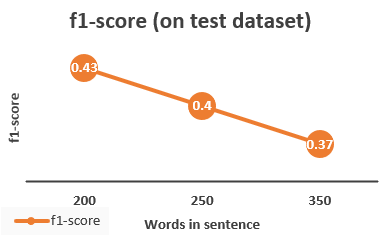

Hence we will use 200 as sequence length for the final model.

#### 2.3.1.2 Normalizing length of reviews - Padding / Truncating

In [ ]:

seq_length = 200

def add_padding(oldcorpus, seq_length):
    corpus = copy.deepcopy(oldcorpus) #Performing a  deepcopy so that text_train_le, text_test_le does not get effected
    output = []
    for sentence in corpus:
      if len(sentence)>seq_length:
        output.append(sentence[:seq_length])  #Truncating the sentence if it is longer than seq_length
      else:
        for j in range(seq_length-len(sentence)): #Padding the sentence if it is smaller than seq_length
          sentence.append("<PAD>")
        output.append(sentence)
    return output

text_train_pad = add_padding(text_train_le,seq_length )
text_test_pad = add_padding(text_test_le,seq_length )



#### 2.3.1.3 Get Character Embeddings

For every word in word_list we will get the character based word embedding and store it so that they can be used for input creation for sentiment analysis.

In [ ]:
CharEmbedModel.eval()

trained_char_based_word_embeddings= []  #list to store character based word embeddings of all words in the dictionary

for word1 in word_list:
  char_input = []
  input_data = [char_dic[n] for n in word1]  #Getting index of each character

  #Adding empty rows in case the word is smaller than the longest word
  diff = maxword_len - len(input_data)
  for x in range(diff):
        input_data.append(0)

  char_input.append(np.eye(char_dic_len)[input_data]) #converting to one-hot encoded vector

  char_input_batch_torch = torch.from_numpy(np.array(char_input)).float().to(device)
  charword2vec,_ = CharEmbedModel(char_input_batch_torch)  #Get the char based embedding of the word
  trained_char_based_word_embeddings.append(charword2vec[0].detach().cpu().numpy())  #Adding to the list for future use

#### 2.3.1.4 Input preparation for sequence model

I have created a function make_embed_forseq to create inputs for the sequence model.

This function will take word dictionary, train data set, word2vec embeddings, character based word embeddings, size, epoch as inputs.

We will **not choose random values** for our model here, rather depending upon the epoch and size we will send the relevant batch and once all data has been used to train the model, we will start from the beginging on the data set again. The idea is for the model to see entire training data set, which might not be possible is we choose random values.

In [ ]:
def make_embed_forseq(corpus,labels,worddict,word2vecembed,charbasedembed,size,epoch):

    emb_dim = 2 * embedding_size # Twice - one for word2vec length and another for character based word embedding length
    input_batch_seq = []
    output_batch_seq = []

    indexes = range(epoch*size,(epoch+1)*size)
    indexes = [r if r < len(corpus) else (r % len(corpus)) for r in indexes] #In case the range is outside the length of the dataset then we start from beginining of the data set

    for i in indexes:
        sentence = corpus[i]
        out_temp = []
        for word in sentence:
            bool_Wordfound = False
            wordindex = 0
            try:  
                wordindex = worddict[word]
                bool_Wordfound = True
            except:  #To handle scenarios where the word is not present in the dictionary 
                bool_Wordfound = False
            if bool_Wordfound == True:
              concat_embed = [*word2vecembed[wordindex] ,*charbasedembed[wordindex]]  #Unpack both word2vec embedding and character based embedding and add to a new list
              out_temp.append(concat_embed)
            else:
                out_temp.append([0]*emb_dim) #If the word is not found in word_dict then create a matrix with all zeros
        input_batch_seq.append(out_temp)
        output_batch_seq.append(labels[i])
    return np.array(input_batch_seq),np.array(output_batch_seq)


### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

**Mode of experiments:**

1. After every 10th epoch, I calculated f1-score (weighted avg) on a fraction of the test reviews(i.e. 2000 of test reviews) as a validation.
2. After all the epochs are done, I calculated f1-score (weighted avg) on the entire test data.
3. After every 10th epoch, I calculated loss and training accuracy on the batch of training data.

I have used the first two (most often second) criteria to decide upon the hyperparameters.

**Epochs - 240**

I have trained different model over 120,240,480,600,720,960 epochs.

f1-score (weighted avg) on the entire test data was better for 240, 600 & 960 epochs. I have chosen 240 of the three with an intention to avoid overfitting. Please refer to **section 3.2** for the visualization.

**Learning Rate - 0.02**

I have tested learning rate - 0.01, 0.02, 0.05 and noticed the below.

*   The final f1-score on test data was same for all learning rate at 240 epochs, after which f1-score decreases at different pace for different learning rate. Please refer to **section 3.2** for the visualizations.
*   The loss was less and fluctuated less for learning rate 0.02.

Hence learning rate 0.02 was considered.

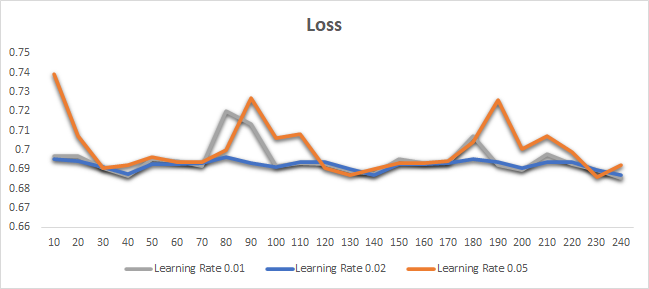


**Neurons in hidden layer (n_hidden) = 50**

I have tried with 50, 100 & 200 hidden neurons and noticed the below.

*   The final f1-score on test data was good for 50 and 200 neurons.
*   Loss was fluctuating less for 50 and 200 neurons.

So 50 was chosen as the time for training the model would be less compared to 200 neurons.

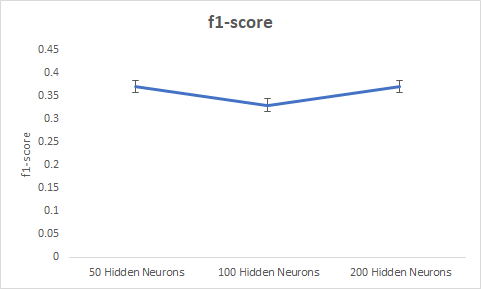


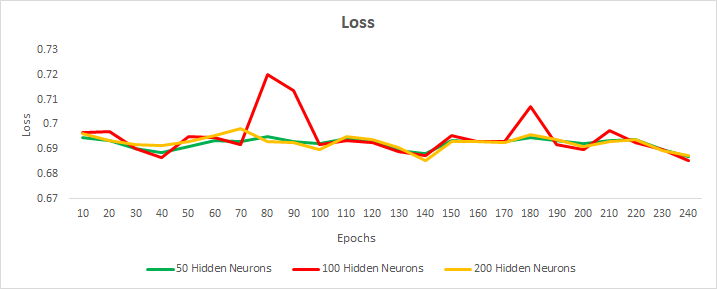


**Batch Size - 250**

I have tried batch sizes 250, 500, 750 and noticed the f1-score on test dataset has been highest for batch with sie 250 and hence chosen the same.

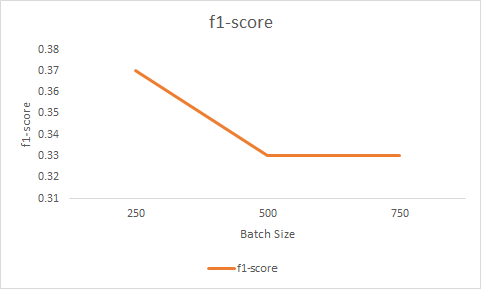

**Input Neurons (n_input) is twice the word embedding size**

As we will be sending word embedding and chracter based word embedding for every word the input neurons will be sum of both the length of the embeddings

**Output Neurons (n_class) is the number of unique sentiments i.e. 2**

In [ ]:
n_input = 2 * embedding_size 
n_hidden = 50 
n_class = len(np.unique(label_train_n)) #number of unique labels
total_epoch = 240
learning_rate = 0.02
seq_batch_size = 250 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.2)
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers=2, batch_first =True, dropout=0.2)
        self.linear = nn.Linear(n_hidden,n_class)

    def forward(self, x):
        x,_ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        x = F.log_softmax(x, dim=1)
        return x

### 2.3.3. Train Sequence Model

In [ ]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_name, best_model_name):
    f_path = checkpoint_name
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_name
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [ ]:
from sklearn.metrics import f1_score

epoch_values = [] #Lists to store epoch values for later plotting
f1_scores = []  #Lists to store f1-values for later plotting

net = Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

start_epoch = 0

#ckp_path = "/content/SeqCheckPoint_59.pt"  #Uncomment to load a check point 
#net, optimizer, start_epoch = load_ckp(ckp_path, net, optimizer) #Uncomment to load a check point 

#Uncomment for debugging
#print("n_hidden",n_hidden)
#print("total_epoch",total_epoch)
#print("learning_rate",learning_rate)
#print("seq_batch_size",seq_batch_size)


for epoch in range(start_epoch,total_epoch):
    #if epoch < 10:  #Uncomment during debugging
    #  print("Epoch "+str(epoch)+" Start Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))  
    input_seq_batch, target_seq_batch = make_embed_forseq(text_train_pad,label_train_n,word_dict,trainedword2vec_embeddings,trained_char_based_word_embeddings,seq_batch_size,epoch)
    
    input_batch_torch = torch.from_numpy(input_seq_batch).float().to(device)
    target_batch_torch = torch.from_numpy(target_seq_batch).view(-1).to(device)

    net.train()
    outputs = net(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    net.eval()
    outputs = net(input_batch_torch)
   # if epoch < 10: #Uncomment during debugging
   #   print("Epoch "+str(epoch)+" End Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
    
    
    if epoch%10 == 9:
        loss = criterion(outputs, target_batch_torch)
        _, predicted = torch.max(outputs, 1)
        acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())

        #Below lines of code to calculate F1 score on test data for plotting.
        epoch_values.append(epoch+1) #Store epoch value for plotting
        #Create batch from test data only for validation and plotting and not for training
        test_seq_batch, testtarget_seq_batch = make_embed_forseq(text_test_pad,label_test_n,word_dict,trainedword2vec_embeddings,trained_char_based_word_embeddings,seq_batch_size,epoch)
        testinput_batch_torch = torch.from_numpy(test_seq_batch).float().to(device)
        test_outputs = net(testinput_batch_torch)   #Perform prediction of test batch
        _, test_predictions = torch.max(test_outputs, 1) 
        tempf1_score = f1_score(testtarget_seq_batch, test_predictions.cpu().numpy(), average='weighted') #calculate f1-score of the test batch
        #print('Epoch: %d, f1-score: %.5f' %(epoch + 1, tempf1_score))
        print('Epoch: %d, loss: %.5f, train_acc: %.2f, f1-score (on test dataset): %.3f' %(epoch + 1, loss.item(), acc, tempf1_score))
        f1_scores.append(tempf1_score)  #Store epoch value for plotting
    #Uncomment to save a check point
    #if epoch % 60 == 59:
    #  print("saving model check point")
    #  checkpoint = {
    #      'epoch': epoch + 1,
    #      'state_dict': net.state_dict(),
    #      'optimizer': optimizer.state_dict()
    #  }
    #  save_ckp(checkpoint, False, "/content/SeqCheckPoint_"+str(epoch)+".pt","/content/SeqCheckPoint_"+str(epoch)+".pt")  


print('Finished Training of Sequence Model')

#Uncomment during debugging
#print(epoch_values)  
#print(f1_scores)


### 2.3.4. Save Sequence Model

In [ ]:
import datetime

from google.colab import drive
drive.mount('/content/gdrive')
SeqModelName = "SeqModelAssignment1V2-"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")+"_LearningRate"+str(learning_rate)+"_n_hidden"+str(n_hidden)+"_total_epoch"+str(total_epoch)+"_batch_size"+str(seq_batch_size)+".pt"

seqpath = F"/content/gdrive/My Drive/"+SeqModelName 
torch.save(net, seqpath)
drive.flush_and_unmount()

### 2.3.5. Load Sequence Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#SeqModelName = "SeqModelAssignment1-16-04-2020-10-01_LearningRate0.01_n_hidden50_total_epoch240_batch_size250_droput_0.2.pt" #comment this to use above saved model

seqpath = F"/content/gdrive/My Drive/"+SeqModelName 
SeqEmbedModel= torch.load(seqpath)
drive.flush_and_unmount()
SeqEmbedModel.eval()

# 3 - Evaluation

## 3.1. Performance Evaluation


As we are not able to create inputs for the entire test test in one go due to RAM issues. We are performing the below in batches

1. Create inputs for 1000 reviews
2. Save the labels for 1000 reviews in test_targets_all
3. Predict the labels using above trained sequence model
4. Save the predictions in test_predictions_all list
 
We are then calculating f1-score on the entire test set in one go.

In [ ]:
test_targets_all = [] #List to store labels of test reviews
test_predictions_all = [] #List to store predictions of test reviews


for k in range(25):  #As we have 1000 in each batch, we are looping 25 times to cover the entire test set. The below function will not randomly pick items.
  test_seq_batch, test_target_seq_batch = make_embed_forseq(text_test_pad,label_test_n,word_dict,trainedword2vec_embeddings,trained_char_based_word_embeddings,1000,k)
  testinput_batch_torch = torch.from_numpy(test_seq_batch).float().to(device)

  test_outputs = SeqEmbedModel(testinput_batch_torch)  #Perform predictions for test set
  _, test_predictions = torch.max(test_outputs, 1)

  test_targets_all.extend(test_target_seq_batch)   #Store labels
  test_predictions_all.extend(test_predictions.cpu().numpy()) #Store predictions


from sklearn.metrics import classification_report
print(classification_report(test_targets_all,test_predictions_all)) #Calculating precision, recall, f1 for test set.

## 3.2. Hyperparameter Testing

**Graph 1** - is drawn using f1-score on the entire test data set with different epoch values for learning rate = 0.01

In [ ]:
# Please comment your code
import matplotlib.pyplot as plt

epochs = [120,240,480,600,720,960]   #These values are captured from previous precitions on test data
f1_scores_testset = [0.33,0.43,0.34,0.43,0.33,0.43] #These values are captured from previous precitions on test data

plt.plot(epochs,f1_scores_testset, label="Learning Rate = 0.01")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Epochs vs Weighted F1 Score on entire Test Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

**Graph 2** - is drawn using f1-score on the entire test data set with different epoch values for learning rate = 0.02

In [ ]:
# Please comment your code
import matplotlib.pyplot as plt

epochs = [120,240,480,600,720,960]   #These values are captured from previous precitions on test data
f1_scores_testset = [0.33,0.43,0.34,0.33,0.33,0.43] #These values are captured from previous precitions on test data

plt.plot(epochs,f1_scores_testset, label="Learning Rate = 0.02")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Epochs vs Weighted F1 Score on entire Test Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

**Graph 3** - is drawn using f1-score on the entire test data set with different epoch values for learning rate = 0.05

In [ ]:
# Please comment your code
import matplotlib.pyplot as plt

epochs = [120,240,480,600,720,960]   #These values are captured from previous precitions on test data
f1_scores_testset = [0.33,0.43,0.43,0.33,0.33,0.43] #These values are captured from previous precitions on test data

plt.plot(epochs,f1_scores_testset, label="Learning Rate = 0.05")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Epochs vs Weighted F1 Score on entire Test Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


**Graph 4** - is drawn using f1-score on 250 reviews of test data set after every 10 epochs with learning rate = 0.0.2

In [ ]:

plt.plot(epoch_values,f1_scores)
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Epochs vs Weighted F1 Score for one batch of Test Set')
plt.show()